# Modeling with Bayesian Regression

Going the Bayesian Route - https://docs.pymc.io/notebooks/GLM-linear.html

In [1]:
# %load ../api_access_snippet.py
#import library
import gspread 
#Service client credential from oauth2client
from oauth2client.service_account import ServiceAccountCredentials
# Print nicely
import pprint
#Create scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#create some credential using that scope and content of startup_funding.json
creds = ServiceAccountCredentials.from_json_keyfile_name('../quickstart/g_sheet_creds.json',scope)
#create gspread authorize using that credential
client = gspread.authorize(creds)
my_email = 'matthewjchristy66@gmail.com'

def read_file(sheet_name):
    out = client.open(sheet_name).sheet1
    out = out.get_all_values()
    out = pd.DataFrame(out, columns = out.pop(0))
    return(out)

import pandas as pd 
import numpy as np

In [2]:
rush = read_file('rushing_data_model_ready')

## Quick Data Cleaning 

In [3]:
target = ['rush_fantasy_pts']
last_week = ['last_week_Yds', 'last_week_TD', 'last_week_rush_fantasy_pts']
inputs = ['yds_ratio', 'fantasy_pts_ratio', 'lag2_Yds', 'lag2_rush_fantasy_pts', 'lag2_TD']
rush = rush.replace('na', np.NaN);
fix_vars = target + last_week + inputs
rush[fix_vars] = rush[fix_vars].astype(float)
rush.loc[rush.rush_fantasy_pts < 0, 'rush_fantasy_pts'] = 0
rush['log1p_target'] = np.log1p(rush.rush_fantasy_pts + 1)
rush['yds_ratio'] = rush['yds_ratio'].fillna(0)
rush['fantasy_pts_ratio'] = rush['fantasy_pts_ratio'].fillna(0)
rush['yds_ratio'] = rush['yds_ratio'].replace([np.inf, -np.inf], 0)
rush['fantasy_pts_ratio'] = rush['fantasy_pts_ratio'].replace([np.inf, -np.inf], 0)

(array([  1.,  12., 107., 209., 233., 183., 184., 185.,  86.,  23.]),
 array([-1.2039728 , -0.71799156, -0.23201032,  0.25397092,  0.73995216,
         1.2259334 ,  1.71191464,  2.19789588,  2.68387712,  3.16985836,
         3.6558396 ]),
 <BarContainer object of 10 artists>)

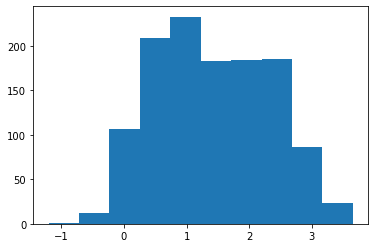

In [14]:
plt.hist(np.log1p(rush.last_week_rush_fantasy_pts));

(array([  1.,   0.,   0.,   1.,   2.,  34., 238., 920.,  22.,   4.]),
 array([-2.30258509, -1.8908932 , -1.47920132, -1.06750943, -0.65581754,
        -0.24412565,  0.16756624,  0.57925813,  0.99095001,  1.4026419 ,
         1.81433379]),
 <BarContainer object of 10 artists>)

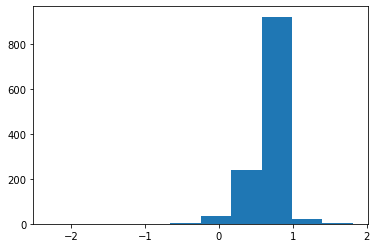

In [12]:
plt.hist(rush.yds_ratio);

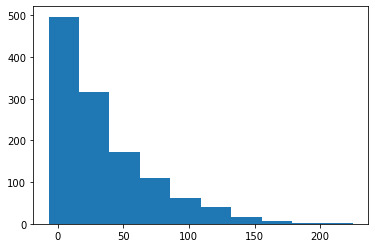

In [20]:
plt.hist(rush.last_week_Yds);

## Loading pymc3 and other packages

In [4]:
import pymc3 as pm
import matplotlib.pyplot as plt

In [5]:
#declaring model formulation
f = 'log1p_target ~ last_week_rush_fantasy_pts + last_week_TD + last_week_Yds + yds_ratio + fantasy_pts_ratio + lag2_Yds + lag2_TD + lag2_rush_fantasy_pts'

### Standard OLS

In [6]:
with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula(f, rush)
    trace = pm.sample(draws = 700, cores=4, init='adapt_diag') # draw 250 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, lag2_rush_fantasy_pts, lag2_TD, lag2_Yds, fantasy_pts_ratio, yds_ratio, last_week_Yds, last_week_TD, last_week_rush_fantasy_pts, Intercept]
Sampling 4 chains: 100%|██████████| 4800/4800 [07:19<00:00, 10.93draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_posterior_predictive(trace, model=model, samples=500)

100%|██████████| 500/500 [00:01<00:00, 322.32it/s]


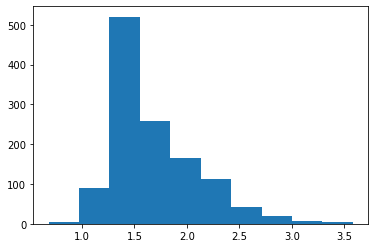

In [17]:
y_pred = np.asarray(ppc['y'].mean(axis = 0))
plt.hist(y_pred);

In [31]:
pred_sd = ppc['y'].std(axis = 0)

Text(0, 0.5, 'outcome')

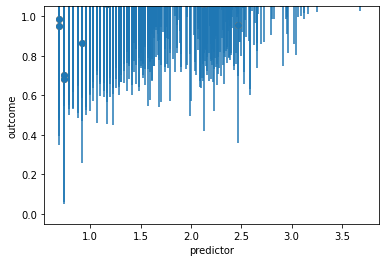

In [32]:
plt.errorbar(x=rush.log1p_target, y=y_pred, yerr=pred_sd, linestyle='', marker='o')
plt.plot(rush.log1p_target, y_pred, 'o')
plt.ylim(-.05, 1.05)
plt.xlabel('predictor')
plt.ylabel('outcome')

### Robust OLS 

In [ ]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula(f, rush, family=family)
    trace_robust = pm.sample(draws = 700, cores=4, init='adapt_diag')